In [1]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import random


class CartPoleEnv3(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    #metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self):
        
        self.force_mag = 1.0
        
        
        high = np.array(
            [
                1,
                100,
                100,
                100,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        d=1
         
        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        
        #t=[1,5,4]
        reward=0
        a=35
        b=50
        k=0
        
        #force is action,random.random()<.37 is attacker probability, x_dot is IP address:
        
        
        if random.random()<.37:
            x = 1
            d+=1*force
            x_dot =x_dot+20+d
            theta = 3
            theta_dot = 4
            k+=1
            d+=1*force
            
            
            
            reward = 1+d
            
            
           
            
        else:
            
            x=0
            x_dot = x_dot+20+d
            theta = 3
            theta_dot = 4
            reward = -(1+d)
            
            
            b+=1
            a-=1
        #if self.kinematics_integrator == "euler":
        #x = t[0][0]
        
          
        self.state = (x, x_dot, theta, theta_dot)

        done = bool(x_dot>5000)
        
        a=a
        b=b
       
        

        return np.array(self.state, dtype=np.float32), reward, done, {}


    def reset(self):
        
        #self.state = self.np_random.randint(low=0, high=1, size=(4,))
       self.state = (1),(1),(1),(1)
      
       #self.state = self.np_random.uniform(low=0, high=0, size=(4,))
       #self.state=self.np.random.uniform(size = (4,), low = 0, high = 1)
       self.steps_beyond_done = None
       return np.array(self.state, dtype=np.float32)

    

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import gym

def plotLearning(x, scores, epsilons,lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

   

<ipython-input-2-d8bb0beb7a3a>:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  state = T.tensor([observation]).to(self.Q_eval.device)


episode  0 score -120.00 average score -120.00 epsilon 0.91
episode  1 score -166.00 average score -143.00 epsilon 0.79
episode  2 score -162.00 average score -149.33 epsilon 0.67
episode  3 score -82.00 average score -132.50 epsilon 0.55
episode  4 score -62.00 average score -118.40 epsilon 0.44
episode  5 score 66.00 average score -87.67 epsilon 0.32
episode  6 score -36.00 average score -80.29 epsilon 0.20
episode  7 score 134.00 average score -53.50 epsilon 0.08
episode  8 score -6.00 average score -48.22 epsilon 0.01
episode  9 score 14.00 average score -42.00 epsilon 0.01
episode  10 score 22.00 average score -36.18 epsilon 0.01
episode  11 score 14.00 average score -32.00 epsilon 0.01
episode  12 score 14.00 average score -28.46 epsilon 0.01
episode  13 score 8.00 average score -25.86 epsilon 0.01
episode  14 score 48.00 average score -20.93 epsilon 0.01
episode  15 score 26.00 average score -18.00 epsilon 0.01
episode  16 score 28.00 average score -15.29 epsilon 0.01
episode  1

episode  143 score 10.00 average score 44.60 epsilon 0.01
episode  144 score 54.00 average score 44.74 epsilon 0.01
episode  145 score -2.00 average score 44.40 epsilon 0.01
episode  146 score 90.00 average score 44.16 epsilon 0.01
episode  147 score -8.00 average score 42.62 epsilon 0.01
episode  148 score 4.00 average score 41.74 epsilon 0.01
episode  149 score 102.00 average score 42.28 epsilon 0.01
episode  150 score -8.00 average score 41.46 epsilon 0.01
episode  151 score 132.00 average score 42.00 epsilon 0.01
episode  152 score 78.00 average score 42.44 epsilon 0.01
episode  153 score 102.00 average score 42.80 epsilon 0.01
episode  154 score -42.00 average score 41.60 epsilon 0.01
episode  155 score 98.00 average score 41.74 epsilon 0.01
episode  156 score 78.00 average score 41.98 epsilon 0.01
episode  157 score 72.00 average score 42.70 epsilon 0.01
episode  158 score 14.00 average score 42.18 epsilon 0.01
episode  159 score 0.00 average score 41.64 epsilon 0.01
episode  160

episode  284 score -10.00 average score 45.18 epsilon 0.01
episode  285 score -24.00 average score 44.46 epsilon 0.01
episode  286 score 6.00 average score 44.28 epsilon 0.01
episode  287 score 54.00 average score 44.22 epsilon 0.01
episode  288 score 208.00 average score 45.68 epsilon 0.01
episode  289 score 48.00 average score 46.00 epsilon 0.01
episode  290 score 48.00 average score 45.24 epsilon 0.01
episode  291 score 34.00 average score 45.58 epsilon 0.01
episode  292 score 86.00 average score 45.12 epsilon 0.01
episode  293 score 114.00 average score 45.18 epsilon 0.01
episode  294 score 78.00 average score 44.76 epsilon 0.01
episode  295 score 18.00 average score 44.14 epsilon 0.01
episode  296 score 34.00 average score 43.70 epsilon 0.01
episode  297 score 108.00 average score 44.62 epsilon 0.01
episode  298 score 86.00 average score 44.60 epsilon 0.01
episode  299 score 60.00 average score 44.72 epsilon 0.01
episode  300 score -8.00 average score 44.24 epsilon 0.01
episode  3

episode  425 score 16.00 average score 49.86 epsilon 0.01
episode  426 score 48.00 average score 50.16 epsilon 0.01
episode  427 score -32.00 average score 48.70 epsilon 0.01
episode  428 score 34.00 average score 48.42 epsilon 0.01
episode  429 score 78.00 average score 49.34 epsilon 0.01
episode  430 score 18.00 average score 48.90 epsilon 0.01
episode  431 score 66.00 average score 49.00 epsilon 0.01
episode  432 score 80.00 average score 49.44 epsilon 0.01
episode  433 score 36.00 average score 49.40 epsilon 0.01
episode  434 score 78.00 average score 49.56 epsilon 0.01
episode  435 score 96.00 average score 49.74 epsilon 0.01
episode  436 score 34.00 average score 50.34 epsilon 0.01
episode  437 score 40.00 average score 51.04 epsilon 0.01
episode  438 score 72.00 average score 50.92 epsilon 0.01
episode  439 score 24.00 average score 50.80 epsilon 0.01
episode  440 score 66.00 average score 51.06 epsilon 0.01
episode  441 score 134.00 average score 52.06 epsilon 0.01
episode  442

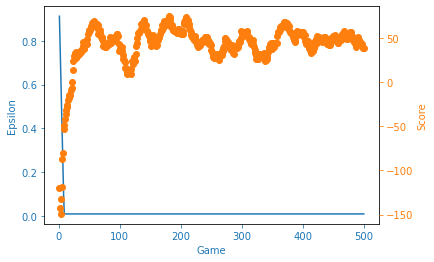

In [4]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

#t=[[0,5,4],[0,4,4],[0,3,4],[0,3,4],[0,3,4],[1,7,4],[1,8,4],[0,3,4],[0,8,4]]
if __name__ == '__main__':
    #env = gym.make('CartPole-v1')
    env=CartPoleEnv3()
    agent = Agent(gamma=0.9, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
                  input_dims=[4], lr=0.01)
    scores, eps_history = [], []
    n_games =500
    x_dot=20
    #dot=[[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25]]
    
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        #observation=env.step(action)
        
        while not done:
            
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)
        
        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    #filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history)

In [ ]:
import random
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[1,7,4],[1,8,4],[1,3,4],[1,8,4]]
for i in range(len(t)):
  r=random.choices(t)
  if random.random()<.5:
        if r[0][0]==1 and random.random()<math.exp(-1):
          print(r[0][1])
  else:
    print('wrong')


In [ ]:
r=math.exp(-1)
print(r)

In [ ]:
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[1,7,4],[1,8,4],[1,3,4],[1,8,4]]
for i in range(len(t)):
    x=t[i][0]+5
    t[i][0]=x
    print(t[i][0])
    

In [ ]:
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[0,7,4],[1,8,4],[1,3,4],[1,8,4]]

a=0
for i in range(len(t)):
  if t[i][0]==1:
     a-=1
    
    
print(a)
    

In [ ]:
 a=0
         for i in range(len(t)):
           if t[i][0]==1:
              a+=1
         b=9-a
        

In [ ]:
np.zeros((5,3), dtype=int)

In [ ]:
[3]*[3]

In [ ]:
%history -g -f MDP_IOT


In [ ]:
%history -g

In [ ]:
state = np_random.uniform(low=0, high=1, size=(4,))


In [ ]:
for i in range(100):
 print(random.random())

In [4]:
s = (2,3)
np.zeros(s)

array([[0., 0., 0.],
       [0., 0., 0.]])

In [2]:
max([4,2],[4,7])

[4, 7]